##Foreground Background Segmentation via Mask R-CNN x GrabCut##

Issue - Some background pixels were classified as foreground pixels when using Mask R-CNN to carry out semantic segmentation.

Solution - Combine Mask R-CNN with GrabCut to get a cleaner, more ideal output.

Process Breakdown:
- Mask R-CNN returns a mask without the user needing to define a bounding box beforehand
- GrabCut takes in the mask as a parameter / seed and further 'refines' it
- Mask R-CNN's bbox is utilized for GrabCut's ROI rectangle
- The function returns either the foreground or background of an image depending on the user's input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch, torchvision

# Check the current torch version
torch.__version__

'1.9.0+cu111'

In [ ]:
# Detectron2 is the improved version of Mask R-CNN
# Clone into the following repository
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13498, done.
remote: Counting objects: 100% (999/999), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 13498 (delta 627), reused 779 (delta 479), pack-reused 12499
Receiving objects: 100% (13498/13498), 5.77 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (9575/9575), done.


In [ ]:
# After running this block, restart runtime
!pip install -e detectron2_repo

Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 49 kB 3.6 MB/s 
     |████████████████████████████████| 74 kB 2.3 MB/s 
     |████████████████████████████████| 145 kB 14.3 MB/s 
     |████████████████████████████████| 130 kB 41.9 MB/s 
     |████████████████████████████████| 743 kB 43.8 MB/s 
     |████████████████████████████████| 749 kB 37.2 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
     |████████████████████████████████| 112 kB 45.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=668db6dad9a8e553339c4e961e41798c80a4cda6a96ce13389168ec8f9529b2b
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=5f95775676d219c8bf5d6879498d15e3c9147e5ddab7979c1d7036c7d48314a4
  Stored in directory: /root/.cache/pip/wheels/

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

folder_dir = "/content/drive/Shared drives/VIP Project/FGBG Segmentation 2.0"

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# Initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"

In [ ]:
from detectron2.modeling import build_model
model = build_model(cfg)  

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS) # Making sure that it's 'Detectron2 Model Zoo'

model_final_a3ec72.pkl: 254MB [00:07, 32.6MB/s]                           


{'__author__': 'Detectron2 Model Zoo'}

In [ ]:
model.eval() # In-depth look of the model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [ ]:
def grabcut(img, final_mask):

    mask = final_mask[:,:,0].copy()

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    x, y, w, h = bbox  # Which coordinate it represents with respect to the foreground -> x: left most, y: top most, w: right most, h: bottom most
    rect = (int(x), int(y), int(w)+1, int(h)+1) # ROI coordinates
    print(rect)

    temp_mask = mask[int(y):int(y)+int(h)+1, int(x):int(x)+int(w)+1] == 1
    mask[int(y):int(y)+int(h)+1, int(x):int(x)+int(w)+1] = (temp_mask*3) # Mask region = probable foreground (represented by 3, 1 represents definite foreground)

    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    return mask2

In [ ]:
def get_mask(image, mask, img_num, content):

    final_mask = np.zeros_like(image)

    for c in range(final_mask.shape[-1]):
        final_mask[:,:,c] = mask.copy()

    mask2 = grabcut(image, final_mask)

    mask2 = np.repeat(mask2[:, :, np.newaxis], 3, axis=2)
    mask2 = cv2.GaussianBlur(mask2, (3, 3), 0)

    foreground = np.copy(image).astype(float)
    foreground[mask2 == 0] = 0
    cv2.imwrite(folder_dir + f'/Foreground/{img_num}.png', foreground)

    background = np.copy(image).astype(float)
    background[mask2 != 0] = 0
    cv2.imwrite(folder_dir + f'/Background/{img_num}.png', background)

    merged = cv2.add(foreground, background)
    cv2.imwrite(folder_dir + f'/Merged/{img_num}.png', merged)

    if content == '1':
      output = foreground
    elif content == '2':
      output = background
    else:
      output = merged

    return output

In [ ]:
class Error(Exception):
    pass

class WrongInput(Error):
    pass

while True:
  try:
    content = input("Foreground (1) -- Background (2) -- Combined (3): ")
    if (content == '1' or content == '2' or content == '3'):
      break
    else:
      raise WrongInput
  except WrongInput:
    print("Please input either 1, 2 or 3!")

Foreground (1) -- Background (2) -- Combined (3): 1


(318, 7, 662, 408)


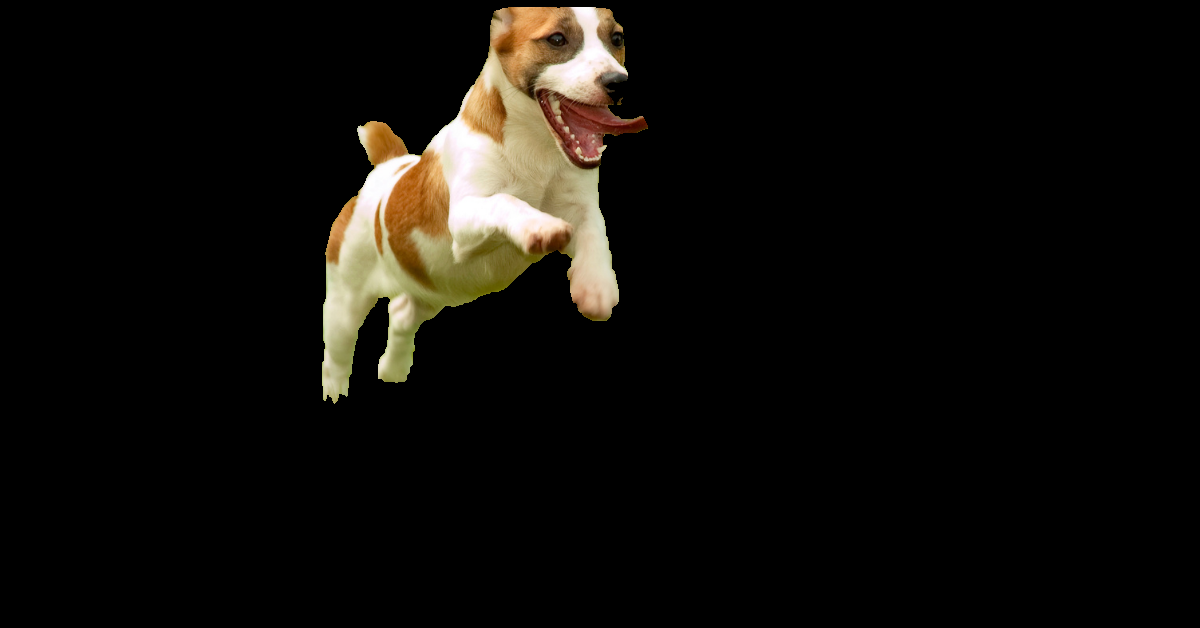

None

(213, 145, 493, 529)


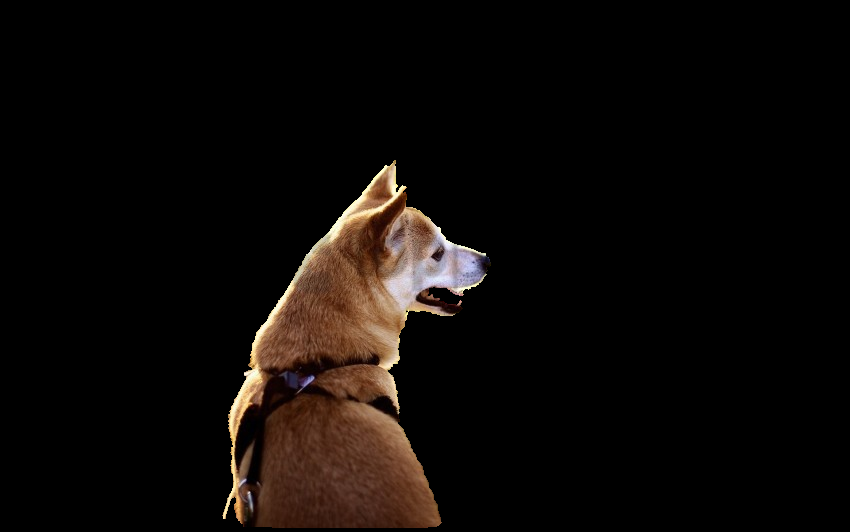

None

(229, 115, 567, 445)


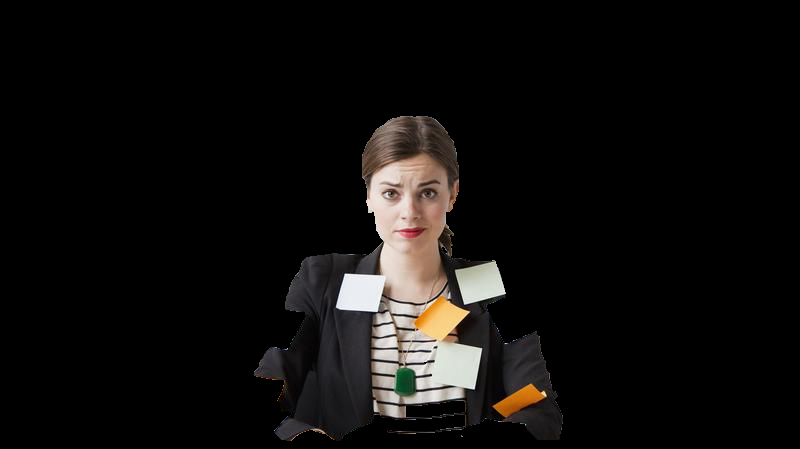

None

In [ ]:
from PIL import Image

img_dir = folder_dir + '/Images'
img_num = 1

for img in os.listdir(img_dir):

  pred = DefaultPredictor(cfg)
  image = cv2.imread(os.path.join(img_dir, img))
  outputs = pred(image)

  bbox = outputs['instances'].get('pred_boxes').tensor.cpu().tolist()[0]
  mask = outputs['instances'].get('pred_masks').cpu().numpy()[0]

  final_image = get_mask(image.copy(), mask.copy(), img_num, content)

  img_num += 1

  display(cv2_imshow(final_image))

### GrabCut works quite well here, save model and import into app.